# Title: Severity of road traffic accidents

In [1]:
%load_ext watermark
%watermark -a "Van Wu" -u -d -t -v -p numpy,pandas,matplotlib,scikit-learn

Author: Van Wu

Last updated: 2025-04-18 22:52:23

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

numpy       : 2.2.4
pandas      : 2.2.3
matplotlib  : 3.10.1
scikit-learn: 1.6.1



## Preparation

- [Github link](https://github.com/Van-Wu1/0006.git)

- Number of words: ***

- Runtime: *** hours (*Memory 32 GB, CPU AMD Ryzen 7 5800H with Radeon Graphics CPU @3.20GHz*)

- Coding environment: Coding environment: VS Code with Jupyter plugin (local), not SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.(used to print Python and package versions for reproducibility.)
    - ......

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

## Research questions

[[ go back to the top ]](#Table-of-contents)

## Data

[[ go back to the top ]](#Table-of-contents)

### 1. Data Description

| Variable                                  | Type         | Description                                                                                  | Notes                        |
|-------------------------------------------|--------------|----------------------------------------------------------------------------------------------|------------------------------|
| accident_severity                       | Categorical  | Severity level of the accident (e.g., slight, serious, fatal)                                | Target variable              |
| number_of_vehicles                      | Numeric      | Number of vehicles involved in the accident                                                  | -                            |
| number_of_casualties                    | Numeric      | Number of casualties involved                                                                | -                            |
| day_of_week                             | Categorical  | Day of the week when the accident occurred (1 = Sunday, ..., 7 = Saturday)                   | One-hot encoding recommended |
| time_hour (derived from time)         | Numeric      | Hour of the day when the accident occurred (e.g., 13:55 → 13)                                | Derived feature              |
| first_road_class                        | Categorical  | Classification of the primary road (1–6, denoting different road types)                      | Ordinal/Categorical          |
| second_road_class                       | Categorical  | Classification of the secondary road                                                         | -                            |
| road_type                               | Categorical  | Type of road (e.g., one-way, dual carriageway, roundabout)                                   | One-hot encoding             |
| speed_limit                             | Numeric      | Speed limit of the road segment (in mph)                                                     | -                            |
| junction_detail                         | Categorical  | Structural detail of the junction                                                            | -                            |
| junction_control                        | Categorical  | Type of junction control (e.g., traffic signal, give way sign)                               | -                            |
| pedestrian_crossing_human_control       | Categorical  | Presence of human-controlled pedestrian crossing                                             | Binary/Categorical           |
| pedestrian_crossing_physical_facilities | Categorical  | Presence of physical pedestrian crossing facilities (e.g., zebra crossing)                   | -                            |
| light_conditions                        | Categorical  | Lighting conditions at the time of the accident                                              | -                            |
| weather_conditions                      | Categorical  | Weather conditions during the accident (e.g., fine, rain, fog)                               | -                            |
| road_surface_conditions                 | Categorical  | Road surface conditions (e.g., dry, wet, icy)                                                | -                            |
| special_conditions_at_site              | Categorical  | Special conditions at the accident site (e.g., roadworks, closure)                           | -                            |
| carriageway_hazards                     | Categorical  | Presence of carriageway hazards (e.g., spillages, obstructions)                              | -                            |
| urban_or_rural_area                     | Categorical  | Whether the area is urban or rural (1 = Urban, 2 = Rural)                                    | Binary (urban = 1)           |
| did_police_officer_attend_scene_of_accident | Categorical  | Whether a police officer attended the scene of the accident                                  | Binary                       |
| trunk_road_flag                         | Categorical  | Whether the accident occurred on a trunk road                                                | Binary                       |
| local_authority_ons_district            | Categorical  | ONS code of the local authority district; useful for spatial join with external datasets     | Useful for joining external data |
| max_betweenness                          | Numeric      | Maximum betweenness centrality of road segments near the accident location                   | Network-based spatial feature |
| ......  | ......  | ......                                    |   |


### 2. Data Import and Prepration

In [2]:
# It would import the packages that would be used first. 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import osmnx as ox
import networkx as nx
import geopandas as gpd
from tqdm import tqdm

In [3]:
# 定义输入输出文件夹
input_folder = '../data/raw'
output_folder = '../data/clean'

In [4]:
# Road Data
df = pd.read_csv('../data/raw/1979-latest-published-year.csv')

# 遍历按照年份提取
for year in [2015, 2016, 2017, 2018, 2019]:
    df_year = df[df['accident_year'] == year]
    print(f"{year} 年的数据量为：{len(df_year)} 条")
    df_year.to_csv(f"../data/raw/{year}.csv", index=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31364\2409204025.py:2: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/1979-latest-published-year.csv')


2015 年的数据量为：140056 条
2016 年的数据量为：136621 条
2017 年的数据量为：129982 条
2018 年的数据量为：122635 条
2019 年的数据量为：117536 条


In [5]:
columns_to_keep = [
    'accident_severity',
    'number_of_vehicles',
    'number_of_casualties',
    'day_of_week',
    'time',
    'first_road_class',
    'second_road_class',
    'road_type',
    'speed_limit',
    'junction_detail',
    'junction_control',
    'pedestrian_crossing_human_control',
    'pedestrian_crossing_physical_facilities',
    'light_conditions',
    'weather_conditions',
    'road_surface_conditions',
    'special_conditions_at_site',
    'carriageway_hazards',
    'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag',
    'local_authority_ons_district'
]

files = {
    '2015.csv': '2015_cleaned.csv',
    '2016.csv': '2016_cleaned.csv',
    '2017.csv': '2017_cleaned.csv',
    '2018.csv': '2018_cleaned.csv',
    '2019.csv': '2019_cleaned.csv'
}

for input_file, output_file in files.items():
    input_path = os.path.join(input_folder, input_file)
    df = pd.read_csv(input_path)

    selected_columns = [col for col in columns_to_keep if col in df.columns]
    df_cleaned = df[selected_columns]

    # 检查缺失值
    missing_counts = df_cleaned.isnull().sum()
    total_missing = missing_counts.sum()

    if total_missing > 0:
        print(f"⚠️  {output_file} has {total_missing} missing values:")
        print(missing_counts[missing_counts > 0])
        
        # 丢弃含缺失值的行
        df_cleaned = df_cleaned.dropna()
        print(f"Dropped rows with missing values. Remaining rows: {len(df_cleaned)}")

    output_path = os.path.join(output_folder, output_file)
    df_cleaned.to_csv(output_path, index=False)
    print(f"{output_file} has been saved in {output_path}, containing {len(df_cleaned.columns)} fields, for {len(df_cleaned)} records.\n")

# df_2019 = pd.read_csv('../data/clean/2019_cleaned.csv')
df_2015= pd.read_csv('../data/clean/2015_cleaned.csv')
df_2016= pd.read_csv('../data/clean/2016_cleaned.csv')
df_2017= pd.read_csv('../data/clean/2017_cleaned.csv')
df_2018= pd.read_csv('../data/clean/2018_cleaned.csv')
df_2019= pd.read_csv('../data/clean/2019_cleaned.csv')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31364\3823314269.py:36: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


2015_cleaned.csv has been saved in ../data/clean\2015_cleaned.csv, containing 22 fields, for 140056 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31364\3823314269.py:36: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


⚠️  2016_cleaned.csv has 37 missing values:
speed_limit    37
dtype: int64
Dropped rows with missing values. Remaining rows: 136584
2016_cleaned.csv has been saved in ../data/clean\2016_cleaned.csv, containing 22 fields, for 136584 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31364\3823314269.py:36: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


2017_cleaned.csv has been saved in ../data/clean\2017_cleaned.csv, containing 22 fields, for 129982 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31364\3823314269.py:36: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


2018_cleaned.csv has been saved in ../data/clean\2018_cleaned.csv, containing 22 fields, for 122635 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31364\3823314269.py:36: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


2019_cleaned.csv has been saved in ../data/clean\2019_cleaned.csv, containing 22 fields, for 117536 records.



In [6]:
# RoadCentrality道路中心性（）
path = "../data/Borough_Boundaries.geojson"
boroughs = gpd.read_file(path)
boroughs = boroughs[["name", "gss_code", "geometry"]].rename(columns={"name": "borough"})

ox.settings.log_console = False
ox.settings.use_cache = True

results = []

for idx, row in tqdm(boroughs.iterrows(), total=len(boroughs), desc="Processing boroughs"):
    borough_name = row["borough"]
    gss_name = row["gss_code"]   
    geometry = row["geometry"]

    try:
        print(f"Processing: {borough_name}")
        
        G = ox.graph_from_polygon(geometry, network_type="drive", simplify=True)

        betweenness = nx.betweenness_centrality(G, weight="length", k=100, seed=42)
        degree = dict(G.degree())
        nx.set_node_attributes(G, betweenness, "betweenness")
        nx.set_node_attributes(G, degree, "degree")

        edge_data = []
        for u, v, key, data in G.edges(keys=True, data=True):
            edge_data.append({
                "u": u,
                "v": v,
                "key": key,
                "geometry": data.get("geometry", None),
                "betweenness": (G.nodes[u]["betweenness"] + G.nodes[v]["betweenness"]) / 2,
                "degree": (G.nodes[u]["degree"] + G.nodes[v]["degree"]) / 2
            })
        edges_df = gpd.GeoDataFrame(edge_data, geometry="geometry", crs="EPSG:4326")

        summary = {
            "borough": borough_name,
            "gss_code": gss_name,
            "mean_betweenness": edges_df["betweenness"].mean(),
            "max_betweenness": edges_df["betweenness"].max(),
            "mean_degree": edges_df["degree"].mean(),
            "max_degree": edges_df["degree"].max(),
            "edge_count": len(edges_df)
        }
        results.append(summary)

    except Exception as e:
        print(f"❌ Failed for {borough_name}: {e}")
        continue

df_results = pd.DataFrame(results)
df_results.to_csv("../data/london_borough_road_centrality.csv", index=False)
print("All done! Results saved to 'london_borough_road_centrality.csv'")

Processing boroughs:   0%|          | 0/33 [00:00<?, ?it/s]

Processing: Kingston upon Thames


Processing boroughs:   3%|▎         | 1/33 [00:05<02:49,  5.29s/it]

Processing: Croydon


Processing boroughs:   6%|▌         | 2/33 [00:17<04:58,  9.62s/it]

Processing: Bromley


Processing boroughs:   9%|▉         | 3/33 [00:31<05:47, 11.59s/it]

Processing: Hounslow


Processing boroughs:  12%|█▏        | 4/33 [00:40<04:59, 10.31s/it]

Processing: Ealing


Processing boroughs:  15%|█▌        | 5/33 [00:48<04:29,  9.61s/it]

Processing: Havering


Processing boroughs:  18%|█▊        | 6/33 [00:56<04:07,  9.17s/it]

Processing: Hillingdon


Processing boroughs:  21%|██        | 7/33 [01:08<04:21, 10.07s/it]

Processing: Harrow


Processing boroughs:  24%|██▍       | 8/33 [01:14<03:39,  8.79s/it]

Processing: Brent


Processing boroughs:  27%|██▋       | 9/33 [01:21<03:16,  8.17s/it]

Processing: Barnet


Processing boroughs:  30%|███       | 10/33 [01:32<03:27,  9.04s/it]

Processing: Lambeth


Processing boroughs:  33%|███▎      | 11/33 [01:40<03:12,  8.76s/it]

Processing: Southwark


Processing boroughs:  36%|███▋      | 12/33 [01:49<03:03,  8.71s/it]

Processing: Lewisham


Processing boroughs:  39%|███▉      | 13/33 [01:57<02:48,  8.44s/it]

Processing: Greenwich


Processing boroughs:  42%|████▏     | 14/33 [02:06<02:47,  8.80s/it]

Processing: Bexley


Processing boroughs:  45%|████▌     | 15/33 [02:14<02:33,  8.53s/it]

Processing: Enfield


Processing boroughs:  48%|████▊     | 16/33 [02:24<02:30,  8.83s/it]

Processing: Waltham Forest


Processing boroughs:  52%|█████▏    | 17/33 [02:30<02:08,  8.03s/it]

Processing: Redbridge


Processing boroughs:  55%|█████▍    | 18/33 [02:37<01:56,  7.75s/it]

Processing: Sutton


Processing boroughs:  58%|█████▊    | 19/33 [02:43<01:42,  7.33s/it]

Processing: Richmond upon Thames


Processing boroughs:  61%|██████    | 20/33 [02:50<01:33,  7.20s/it]

Processing: Merton


Processing boroughs:  64%|██████▎   | 21/33 [02:56<01:22,  6.87s/it]

Processing: Wandsworth


Processing boroughs:  67%|██████▋   | 22/33 [03:05<01:20,  7.27s/it]

Processing: Hammersmith and Fulham


Processing boroughs:  70%|██████▉   | 23/33 [03:08<01:02,  6.20s/it]

Processing: Kensington and Chelsea


Processing boroughs:  73%|███████▎  | 24/33 [03:12<00:47,  5.33s/it]

Processing: Westminster


Processing boroughs:  76%|███████▌  | 25/33 [03:18<00:45,  5.64s/it]

Processing: Camden


Processing boroughs:  79%|███████▉  | 26/33 [03:23<00:38,  5.50s/it]

Processing: Tower Hamlets


Processing boroughs:  82%|████████▏ | 27/33 [03:30<00:34,  5.76s/it]

Processing: Islington


Processing boroughs:  85%|████████▍ | 28/33 [03:34<00:27,  5.44s/it]

Processing: Hackney


Processing boroughs:  88%|████████▊ | 29/33 [03:39<00:21,  5.34s/it]

Processing: Haringey


Processing boroughs:  91%|█████████ | 30/33 [03:45<00:16,  5.42s/it]

Processing: Newham


Processing boroughs:  94%|█████████▍| 31/33 [03:53<00:12,  6.14s/it]

Processing: Barking and Dagenham


Processing boroughs:  97%|█████████▋| 32/33 [03:58<00:05,  5.78s/it]

Processing: City of London


Processing boroughs: 100%|██████████| 33/33 [03:59<00:00,  7.27s/it]

All done! Results saved to 'london_borough_road_centrality.csv'


In [7]:
#Join
# 设置路径
accident_folder = "../data/clean"
centrality_path = "../data/london_borough_road_centrality.csv"
data_with_centrality = "../data/final"

# 读取道路中心性数据
df_centrality = pd.read_csv(centrality_path)

# 循环处理每一年
for year in range(2015, 2020):
    accident_file = f"{year}_cleaned.csv"
    accident_path = os.path.join(accident_folder, accident_file)

    if not os.path.exists(accident_path):
        print(f"❌ File not found: {accident_path}")
        continue

    # 读取事故数据
    df_accident = pd.read_csv(accident_path)

    # 合并中心性数据
    df_merged = df_accident.merge(
        df_centrality,
        how="left",
        left_on="local_authority_ons_district",
        right_on="gss_code"
    )

    # 删除没有中心性值的行（非伦敦地区）
    before_drop = len(df_merged)
    df_merged = df_merged.dropna(subset=["mean_betweenness"])
    after_drop = len(df_merged)
    dropped = before_drop - after_drop

    # 输出文件
    output_path = os.path.join(data_with_centrality, f"{year}_with_centrality.csv")
    df_merged.to_csv(output_path, index=False)

    print(f"✅ {year} saved with centrality! Rows kept: {after_drop}, dropped: {dropped}")

✅ 2015 saved with centrality! Rows kept: 25193, dropped: 114863
✅ 2016 saved with centrality! Rows kept: 25125, dropped: 111459
✅ 2017 saved with centrality! Rows kept: 27011, dropped: 102971
✅ 2018 saved with centrality! Rows kept: 25622, dropped: 97013
✅ 2019 saved with centrality! Rows kept: 25310, dropped: 92226


In [8]:
import pandas as pd
import os

# 定义年份和路径
years = [2015, 2016, 2017, 2018, 2019]
dfs = []

for year in years:
    path = f"../data/final/{year}_with_centrality.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        df["year"] = year
        dfs.append(df)
    else:
        print(f"File not found: {path}")

# 合并所有年份数据
df = pd.concat(dfs, ignore_index=True)
df.to_csv("../data/final/all_years_with_centrality.csv", index=False)


### 3. Data Pattern Analysis

In [9]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())   # 缺失值检查
df.describe()              # 数值特征统计
df["accident_severity"].value_counts(normalize=True)  # 类别分布

(128261, 30)
accident_severity                                int64
number_of_vehicles                               int64
number_of_casualties                             int64
day_of_week                                      int64
time                                            object
first_road_class                                 int64
second_road_class                                int64
road_type                                        int64
speed_limit                                    float64
junction_detail                                  int64
junction_control                                 int64
pedestrian_crossing_human_control                int64
pedestrian_crossing_physical_facilities          int64
light_conditions                                 int64
weather_conditions                               int64
road_surface_conditions                          int64
special_conditions_at_site                       int64
carriageway_hazards                              int

accident_severity
3    0.876089
2    0.119179
1    0.004733
Name: proportion, dtype: float64

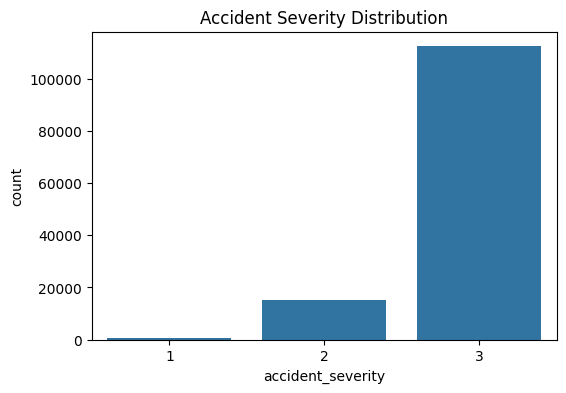

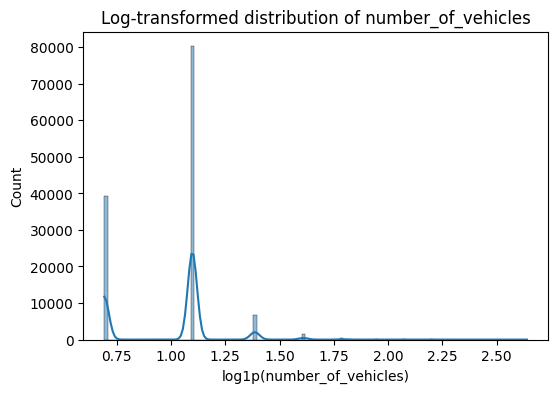

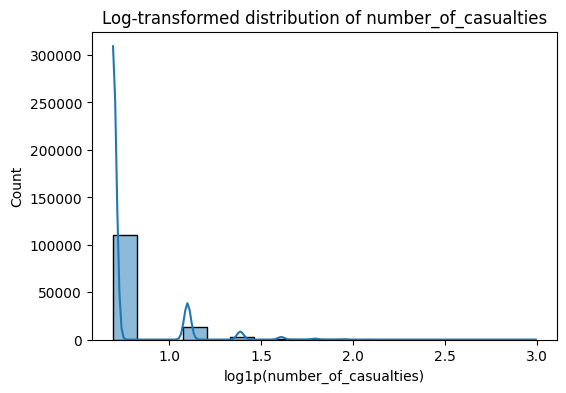

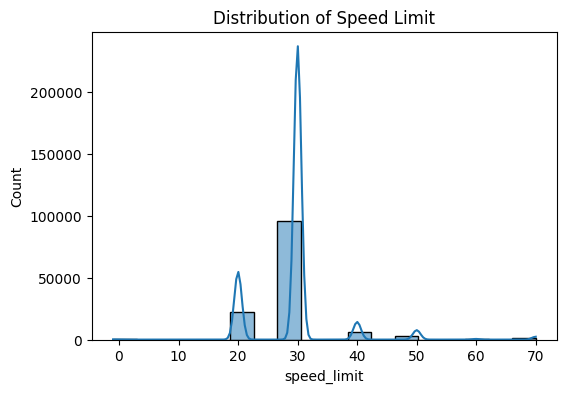

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 事故严重程度分布
plt.figure(figsize=(6,4))
sns.countplot(x="accident_severity", data=df)
plt.title("Accident Severity Distribution")
plt.show()


# 数值型：车数、伤亡数、限速
for col in ["number_of_vehicles", "number_of_casualties"]:
    plt.figure(figsize=(6, 4))
    sns.histplot(np.log1p(df[col]), kde=True)  # log1p(x) = log(x + 1)，避免 log(0) 报错
    plt.title(f"Log-transformed distribution of {col}")
    plt.xlabel(f"log1p({col})")
    plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["speed_limit"], kde=True)
plt.title("Distribution of Speed Limit")
plt.xlabel("speed_limit")
plt.ylabel("Count")
plt.show()


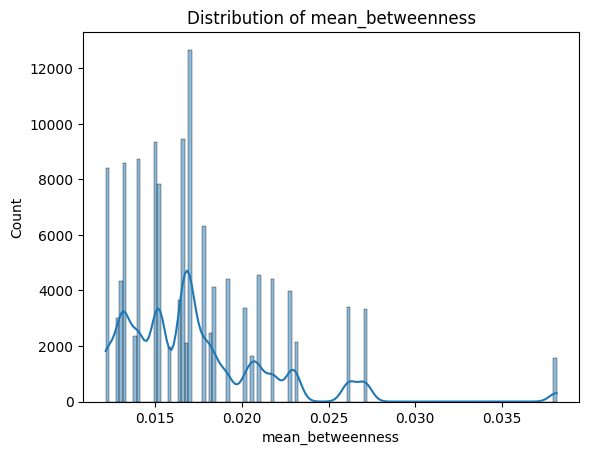

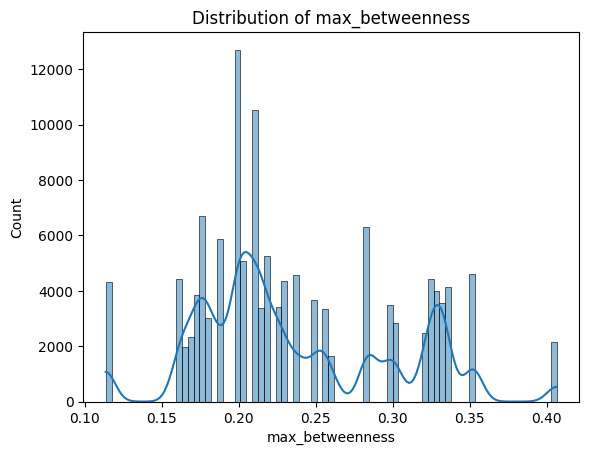

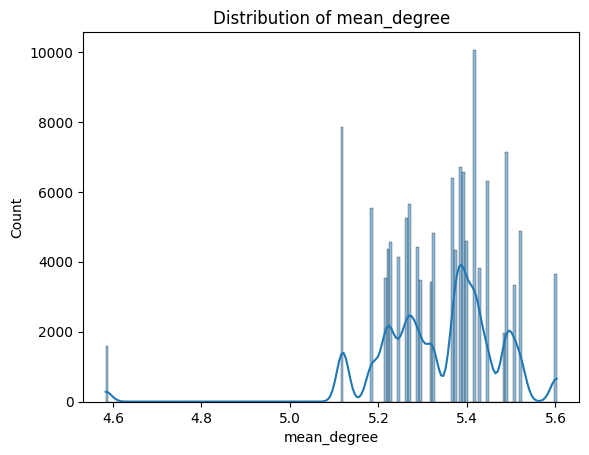

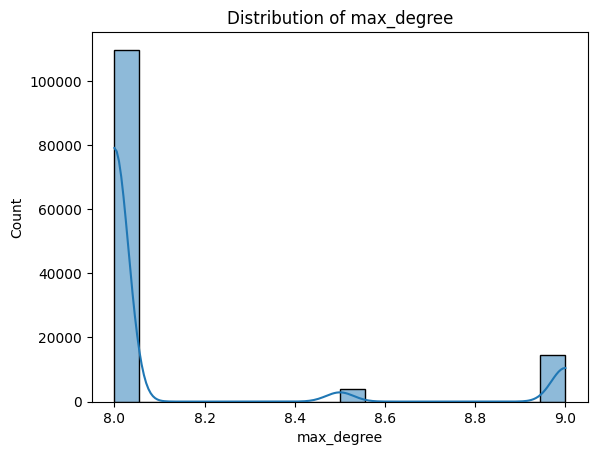

In [11]:
# 中心性变量分布（单变量 + 空值检查）
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

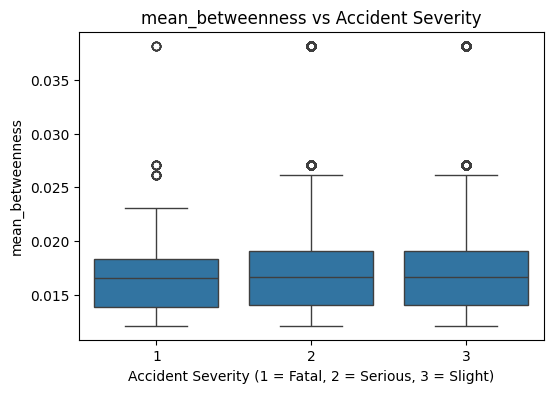

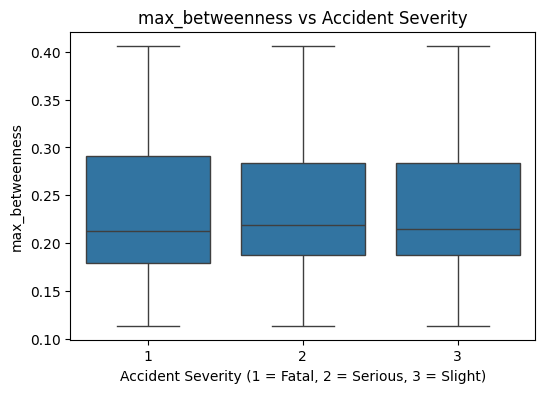

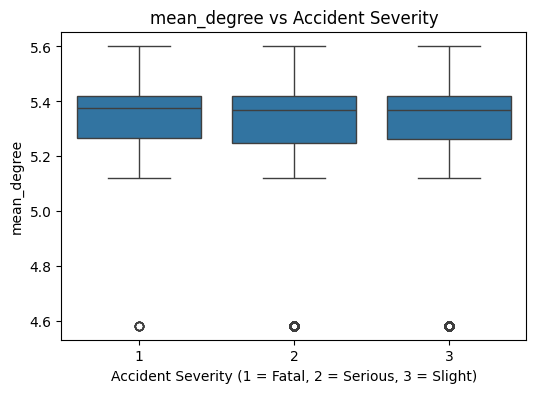

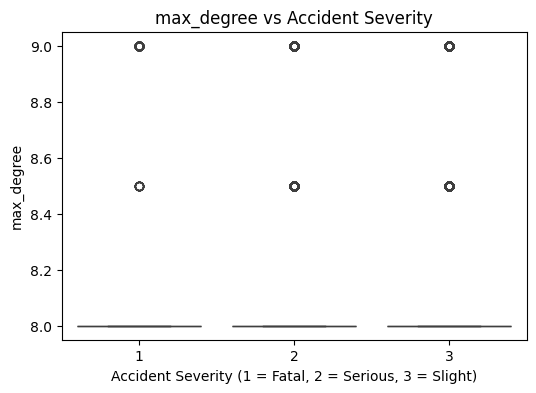

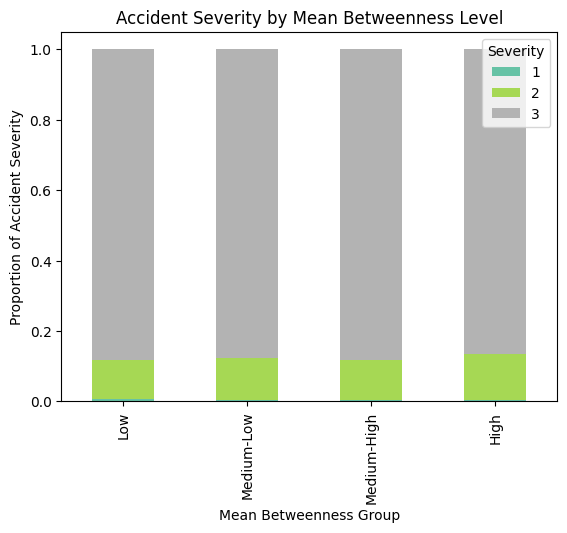

Text(0.5, 1.0, 'Accident Severity by Day of Week')

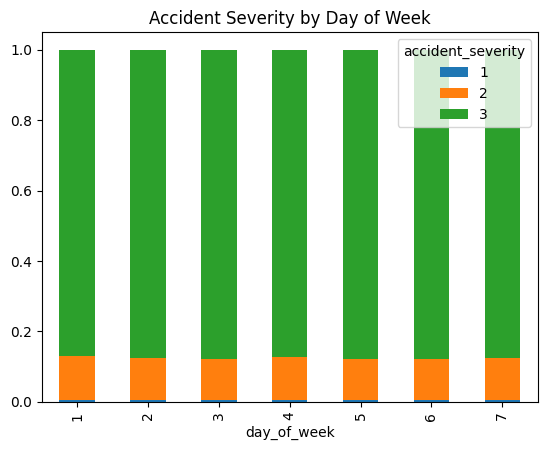

In [12]:
# 变量与事故严重程度的关系（双变量分析）
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="accident_severity", y=col, data=df)
    plt.title(f"{col} vs Accident Severity")
    plt.xlabel("Accident Severity (1 = Fatal, 2 = Serious, 3 = Slight)")
    plt.ylabel(col)
    plt.show()

# 将 mean_betweenness 分为 4 个等级（四分位）
df["betweenness_level"] = pd.qcut(df["mean_betweenness"], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])

# 查看每组的事故严重程度比例
severity_by_level = pd.crosstab(df["betweenness_level"], df["accident_severity"], normalize='index')

# 画分组堆叠条形图
severity_by_level.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Accident Severity by Mean Betweenness Level")
plt.xlabel("Mean Betweenness Group")
plt.ylabel("Proportion of Accident Severity")
plt.legend(title="Severity", loc="upper right")
plt.show()


# 类别型变量可交叉表分析：
pd.crosstab(df["day_of_week"], df["accident_severity"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Accident Severity by Day of Week")

从箱线图和堆叠条形图可以看出，道路网络的最大中介中心性（max_betweenness）在不同事故严重程度之间具有更明显的区分度，尤其在致命事故中普遍更高。而平均中介中心性（mean_betweenness）则呈现轻微的变化，说明其在大尺度上影响有限，但仍具备潜在的建模价值。相比之下，度中心性（degree centrality）在不同类别中的分布差异不明显，解释力较弱。

According to the boxplots and grouped bar charts, maximum betweenness centrality (max_betweenness) shows stronger differentiation across accident severity levels, especially with higher values in fatal accidents. In contrast, mean_betweenness exhibits weaker variation, indicating a more subtle influence. Degree-based indicators, particularly max_degree, show very limited discriminative power and may not be useful in predictive modeling.

## Methodology

[[ go back to the top ]](#Table-of-contents)

*[Note: a flow chart that describes the methodology is strongly encouraged - see the example below. This flow chart can be made using Microsoft powerpoint or visio or other software]*

Source: see [link](https://linkinghub.elsevier.com/retrieve/pii/S2210670722004437).

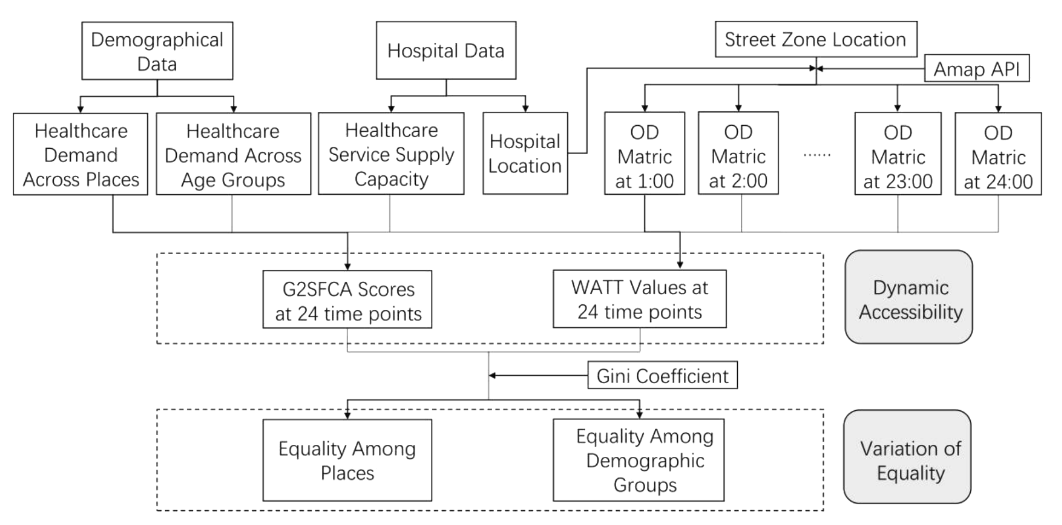

# 20250416 从这里开始做，编码-跑三个模型

In [13]:
# One-hot encoding + 保存
categorical_vars = [
    'day_of_week', 'road_type', 'light_conditions', 'weather_conditions',
    'road_surface_conditions', 'junction_control', 'junction_detail',
    'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities',
    'special_conditions_at_site', 'carriageway_hazards', 'first_road_class',
    'second_road_class', 'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag', 'urban_or_rural_area'
]

# 1. 编码
df_encoded = pd.get_dummies(df.copy(), columns=categorical_vars, drop_first=True)

# 2. 将布尔列转换为整数
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# 3. 检查数据类型分布
print("✅ Column types:\n", df_encoded.dtypes.value_counts())

# 从原始 time 列中提取小时数（必须先确保 time 存在）
df_encoded["time_hour"] = pd.to_datetime(df_encoded["time"], format="%H:%M", errors="coerce").dt.hour

✅ Column types:
 int64       89
float64      6
object       4
category     1
Name: count, dtype: int64


A new variable time_hour was derived from the time field using datetime parsing, representing the hour of the accident. Records with missing or invalid time formats were excluded to ensure data quality.

In [14]:
print(df_encoded.columns)
print(df_encoded)

Index(['accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'time', 'speed_limit', 'local_authority_ons_district', 'borough',
       'gss_code', 'mean_betweenness', 'max_betweenness',
       ...
       'second_road_class_4', 'second_road_class_5', 'second_road_class_6',
       'did_police_officer_attend_scene_of_accident_2',
       'did_police_officer_attend_scene_of_accident_3', 'trunk_road_flag_1',
       'trunk_road_flag_2', 'urban_or_rural_area_2', 'urban_or_rural_area_3',
       'time_hour'],
      dtype='object', length=101)
        accident_severity  number_of_vehicles  number_of_casualties   time  \
0                       3                   1                     1  18:45   
1                       3                   1                     1  07:50   
2                       3                   1                     1  18:08   
3                       3                   1                     1  07:40   
4                       2                   2       

In [15]:
# Ordinal 编码 betweenness_level（在逻辑回归中需要注明）
betweenness_mapping = {
    'Low': 0,
    'Medium-Low': 1,
    'Medium-High': 2,
    'High': 3
}
df_encoded['betweenness_level_encoded'] = df_encoded['betweenness_level'].map(betweenness_mapping)
df_encoded.drop(columns=['betweenness_level'], inplace=True)

# 2. 删除不可建模字段
df_encoded.drop(columns=['time', 'borough', 'gss_code'], inplace=True)

In [16]:
df_encoded = df_encoded.drop(columns=['local_authority_ons_district', 'year'])

In [17]:
df_encoded.to_csv("../data/final/encode201519.csv", index=False)
print("📁 Data saved to '../data/final/encode_all_years_with_centrality.csv'")

📁 Data saved to '../data/final/encode_all_years_with_centrality.csv'


All categorical variables were either one-hot encoded or ordinal-encoded. The time variable was converted to time_hour, and betweenness_level was ordinally mapped to an integer scale. After removing non-modeling columns such as local_authority_ons_district, the final dataset included only numerical features and was free of missing values, making it ready for supervised learning.

In [18]:
import pandas as pd

# 1. 读取数据
df = pd.read_csv("../data/final/encode201519.csv")

# 2. 查看基本结构
print("🔍 DataFrame Info:")
print(df.info())

# 3. 缺失值检查
print("\n🧼 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

# 4. 数据类型统计
print("\n📊 数据类型分布:")
print(df.dtypes.value_counts())

# 5. 检查 object 类型字段（可能是未编码的列）
print("\n⚠️ Object 类型字段及其唯一值数:")
obj_cols = df.select_dtypes(include='object')
print(obj_cols.nunique().sort_values(ascending=False))


🔍 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128261 entries, 0 to 128260
Data columns (total 96 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   accident_severity                              128261 non-null  int64  
 1   number_of_vehicles                             128261 non-null  int64  
 2   number_of_casualties                           128261 non-null  int64  
 3   speed_limit                                    128261 non-null  float64
 4   mean_betweenness                               128261 non-null  float64
 5   max_betweenness                                128261 non-null  float64
 6   mean_degree                                    128261 non-null  float64
 7   max_degree                                     128261 non-null  float64
 8   edge_count                                     128261 non-null  float64
 9   day_of_week_2      

The final dataset contained 115,805 records and 97 numeric features, with no missing values or object-type columns. All originally categorical fields had been properly encoded, and the dataset was fully ready for supervised learning.

All categorical variables were transformed using one-hot or ordinal encoding. No missing values were present in the dataset. Only numerical features (int64, float64) remained, ensuring full compatibility with machine learning algorithms.

## 数据应该是没问题了，需要后续在检查一下，至少目前的格式没有问题 20240416
## 模型起步

In [19]:
# 构建特征与标签
X = df.drop(columns=["accident_severity"])
y = df["accident_severity"]

# 划分数据集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [20]:
# 定义评估函数
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    print(f"\n🔍 {name} Classification Report")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


## Logistic Regression

Fitting 3 folds for each of 8 candidates, totalling 24 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression 最佳参数： {'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__multi_class': 'multinomial', 'logreg__solver': 'lbfgs'}
✅ Logistic Regression 最佳 macro-F1 分数： 0.31131382813268343

🔍 Logistic Regression Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       122
           2       0.00      0.00      0.00      3057
           3       0.88      1.00      0.93     22474

    accuracy                           0.88     25653
   macro avg       0.29      0.33      0.31     25653
weighted avg       0.77      0.88      0.82     25653



e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


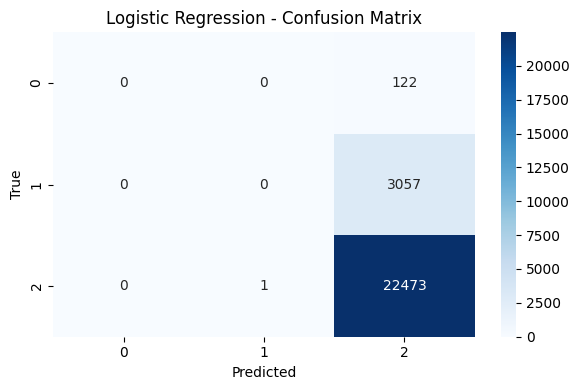

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline（标准化 + 逻辑回归）
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

# 参数网格
logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__class_weight': ['balanced', None],
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['lbfgs']
}

# 网格搜索
grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 训练
grid_search_logreg.fit(X_train, y_train)
print("✅ Logistic Regression 最佳参数：", grid_search_logreg.best_params_)
print("✅ Logistic Regression 最佳 macro-F1 分数：", grid_search_logreg.best_score_)

# 预测 + 可视化
y_pred_log = grid_search_logreg.best_estimator_.predict(X_test)
print("\n🔍 Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log))

# 混淆矩阵
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Random Forest

Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ RF 最佳参数： {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
✅ RF 最佳 macro-F1 分数： 0.3522145051595327
              precision    recall  f1-score   support

           1       0.01      0.28      0.03       122
           2       0.17      0.33      0.23      3057
           3       0.90      0.70      0.79     22474

    accuracy                           0.65     25653
   macro avg       0.36      0.43      0.35     25653
weighted avg       0.81      0.65      0.72     25653



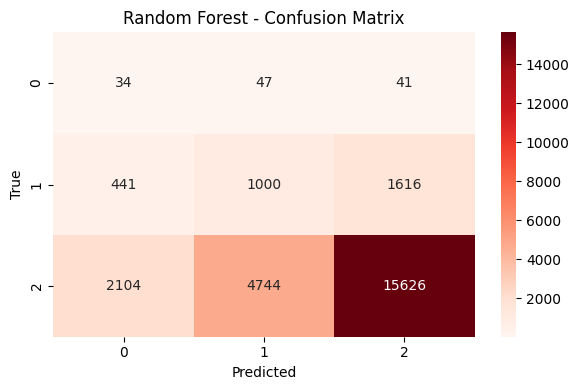

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# 创建 pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 虽然 RF 不敏感于缩放，但为了统一格式可保留
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 参数网格
rf_param_grid = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__class_weight': ['balanced', None]
}

# 网格搜索
grid_search_rf = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 训练
grid_search_rf.fit(X_train, y_train)

# 输出结果
print("✅ RF 最佳参数：", grid_search_rf.best_params_)
print("✅ RF 最佳 macro-F1 分数：", grid_search_rf.best_score_)

# 评估
from sklearn.metrics import classification_report

y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## XGBoost

Fitting 3 folds for each of 96 candidates, totalling 288 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
e:\Software\Study\python-3.13.2\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:06:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost 最佳参数： {'xgb__colsample_bytree': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.8}
✅ XGBoost 最佳 macro-F1 分数： 0.3200243808628746

🔍 XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.17      0.01      0.02       122
           1       0.21      0.01      0.02      3057
           2       0.88      0.99      0.93     22474

    accuracy                           0.87     25653
   macro avg       0.42      0.34      0.32     25653
weighted avg       0.79      0.87      0.82     25653



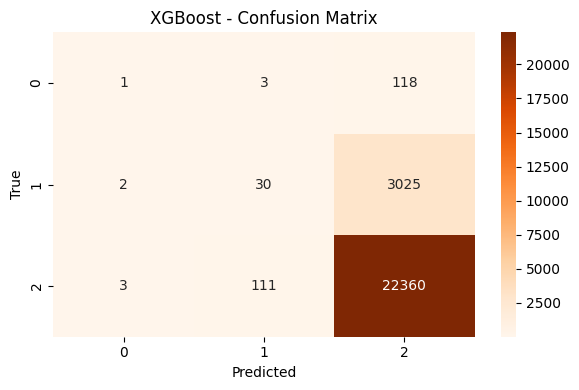

In [23]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=3,
        use_label_encoder=False,
        random_state=42
    ))
])

# 参数网格
xgb_param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [6, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1],
    'xgb__scale_pos_weight': [1, 10, 30]
}

# 网格搜索
grid_search_xgb = GridSearchCV(
    xgb_pipeline, xgb_param_grid, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1
)

# 将 y 标签统一减 1，使其变为 [0, 1, 2]
y_train = y_train - 1
y_test = y_test - 1


# 训练
grid_search_xgb.fit(X_train, y_train)
print("✅ XGBoost 最佳参数：", grid_search_xgb.best_params_)
print("✅ XGBoost 最佳 macro-F1 分数：", grid_search_xgb.best_score_)

# 预测 + 可视化
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
print("\n🔍 XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

# 混淆矩阵
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 32 candidates, totalling 96 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:13:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost + SMOTE 最佳参数： {'xgb__colsample_bytree': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.8}
✅ XGBoost + SMOTE 最佳 macro-F1 分数： 0.9286697911934653

🔍 XGBoost + SMOTE Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.16      0.05      0.07      3057
           2       0.88      0.97      0.92     22474

    accuracy                           0.85     25653
   macro avg       0.35      0.34      0.33     25653
weighted avg       0.79      0.85      0.82     25653



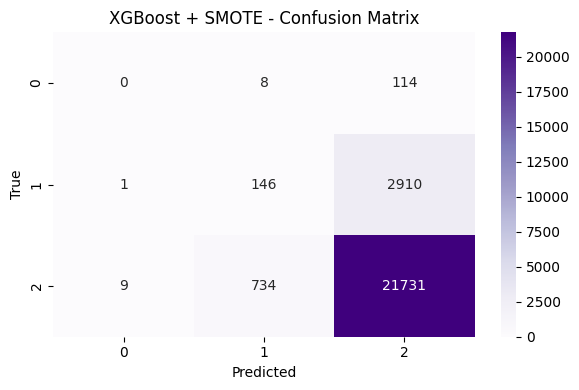

In [24]:
# +smote
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1：SMOTE 过采样
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ✅ Step 2：构建 Pipeline
xgb_pipeline_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=3,
        use_label_encoder=False,
        random_state=42
    ))
])

# ✅ Step 3：参数网格
xgb_param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [6, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1],
    'xgb__scale_pos_weight': [1]  # SMOTE 平衡了类别，这里不用再调
}

# ✅ Step 4：网格搜索
grid_search_xgb_smote = GridSearchCV(
    xgb_pipeline_smote,
    xgb_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# ✅ Step 5：训练
grid_search_xgb_smote.fit(X_train_smote, y_train_smote)
print("✅ XGBoost + SMOTE 最佳参数：", grid_search_xgb_smote.best_params_)
print("✅ XGBoost + SMOTE 最佳 macro-F1 分数：", grid_search_xgb_smote.best_score_)

# ✅ Step 6：预测与评估
y_pred_xgb_smote = grid_search_xgb_smote.best_estimator_.predict(X_test)
print("\n🔍 XGBoost + SMOTE Classification Report")
print(classification_report(y_test, y_pred_xgb_smote))

# ✅ Step 7：混淆矩阵可视化
cm_smote = confusion_matrix(y_test, y_pred_xgb_smote)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Purples')
plt.title("XGBoost + SMOTE - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

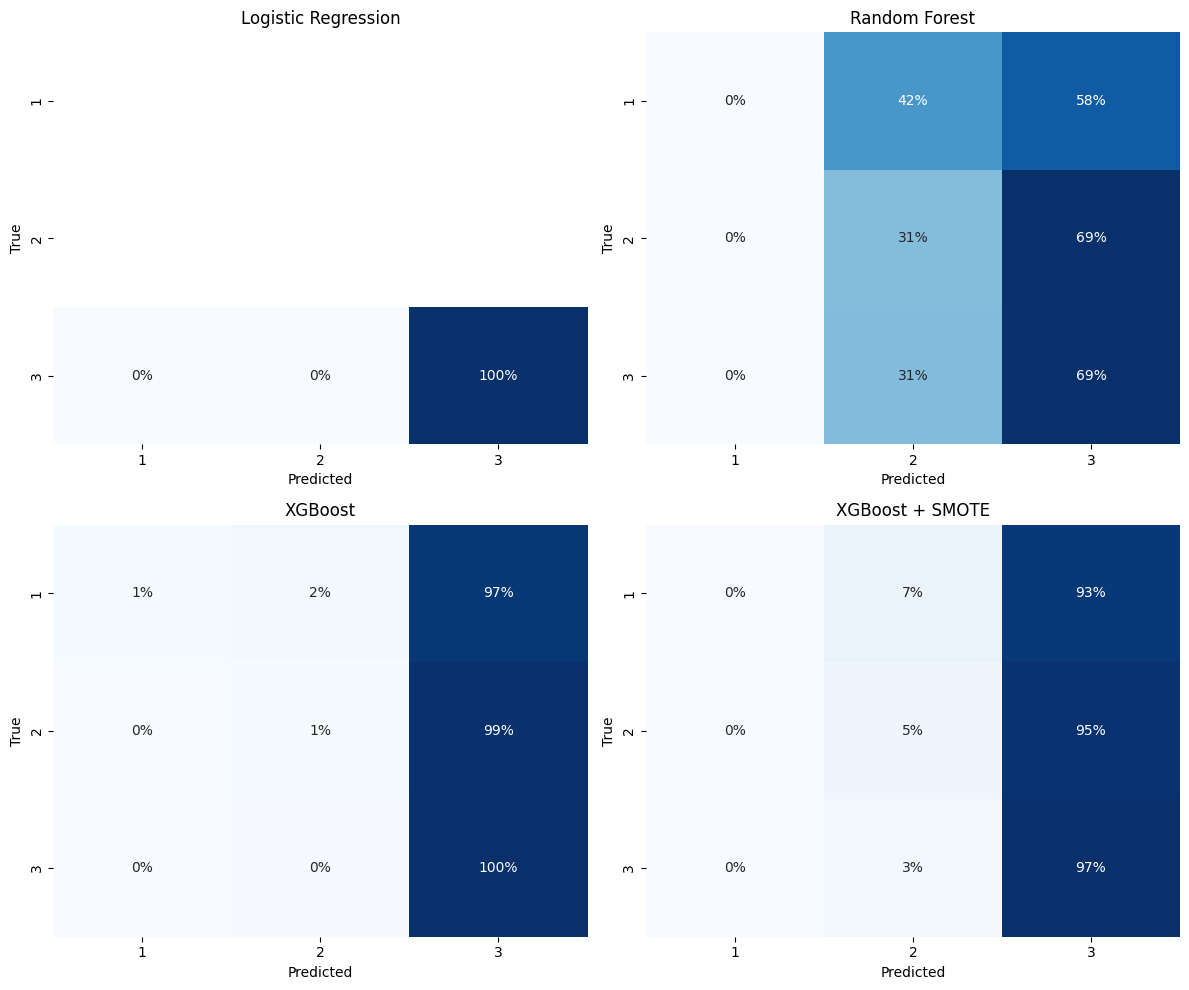

In [25]:
# 2*2误差性分析
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ 恢复标签（如果做过 -1）
y_test_plot = y_test + 1
y_pred_log_plot = y_pred_log + 1
y_pred_rf_plot = y_pred_rf + 1
y_pred_xgb_plot = y_pred_xgb + 1
y_pred_xgb_smote_plot = y_pred_xgb_smote + 1

# ✅ 标签顺序
labels = [1, 2, 3]

# ✅ 模型信息
model_names = ["Logistic Regression", "Random Forest", "XGBoost", "XGBoost + SMOTE"]
y_preds = [y_pred_log_plot, y_pred_rf_plot, y_pred_xgb_plot, y_pred_xgb_smote_plot]

# ✅ 可视化函数
def plot_misclassification(y_test, y_pred, title, ax):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_percent = cm_df.div(cm_df.sum(axis=1), axis=0).round(3)
    sns.heatmap(cm_percent, annot=True, fmt=".0%", cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# ✅ 创建 2x2 子图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2行2列，适配4个图
axes = axes.flatten()  # 将 2x2 数组展开成一维列表以便迭代

# ✅ 遍历绘图
for ax, pred, name in zip(axes, y_preds, model_names):
    plot_misclassification(y_test_plot, pred, name, ax)

plt.tight_layout()
plt.show()

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

## Conclusion

[[ go back to the top ]](#Table-of-contents)

## References

[[ go back to the top ]](#Table-of-contents)